# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from torchtext import data
import re
# custom path
os.chdir('../..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
def flatten_category(labelled_data):
    """ convert multiple labels to multiple rows """
    data = []
    for i, row in tqdm(labelled_data.iterrows(), desc='rows'):
        for t,w in row['category'].items():
            row['topic'] = t
            row['weight'] = w
            data.append(row)
    data = pd.DataFrame(data)
    return data

## Data prep

In [10]:
DATA = 'data/interim/train_data.csv'

TEST_SIZE = 0.33
TEST_SETS = ['r-1_completions', 'r-2_completions']

### Load

In [7]:
data = pd.read_csv(DATA,)
data['description'].fillna("", inplace=True)
data['category'] = data['category'].apply(eval)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33165 entries, 0 to 33164
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         33165 non-null  object 
 1   description   33165 non-null  object 
 2   recent_posts  33165 non-null  object 
 3   lang_code     33165 non-null  object 
 4   id            1133 non-null   float64
 5   category      33165 non-null  object 
 6   subset        33165 non-null  object 
 7   text          33165 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.0+ MB


In [11]:
LANGS = data['lang_code'].unique()

### Split

take a percentage for testing from selected subsets

In [8]:
data['subset'].value_counts()

tg_true            31501
r-1_completions      691
tg_downloads         531
r-2_completions      442
Name: subset, dtype: int64

In [28]:
rand_true = lambda test_prob: np.random.choice([True,False], p=[test_prob, 1 - test_prob])

In [29]:
def select_test(data, test_subsets=None,  test_size=0.3):
    """ Return True for test set and False for train """
    if test_subsets is None:
        test_subsets = data['subset'].unique().tolist()
    is_test = data.apply(lambda x: rand_true(test_size) if x['subset'] in test_subsets else False,
              axis=1)
    return is_test

In [33]:
data['is_test'] = select_test(data, test_size=TEST_SIZE, test_subsets=TEST_SETS)

data.groupby(['lang_code','subset'])['is_test'].mean()

lang_code  subset         
ar         r-2_completions    0.312500
en         r-1_completions    0.320988
           r-2_completions    0.351648
           tg_downloads       0.000000
           tg_true            0.000000
fa         r-2_completions    0.325581
ru         r-1_completions    0.332425
           r-2_completions    0.343137
           tg_downloads       0.000000
           tg_true            0.000000
uz         r-2_completions    0.385542
Name: is_test, dtype: float64

In [34]:
train_data = data.loc[~data['is_test']]

test_data = data.loc[data['is_test']]

print(train_data.shape)
print(test_data.shape)

(32787, 9)
(378, 9)


### Flatten train data

Create each category as a separate row, since sklearn can't handle multi-prob

In [35]:
train_data_flat = flatten_category(train_data,)

train_data_flat.shape

rows: 0it [00:00, ?it/s]

(68102, 11)

### Topic distribution

In [36]:
from src.train.plot_utils import barplots

ru


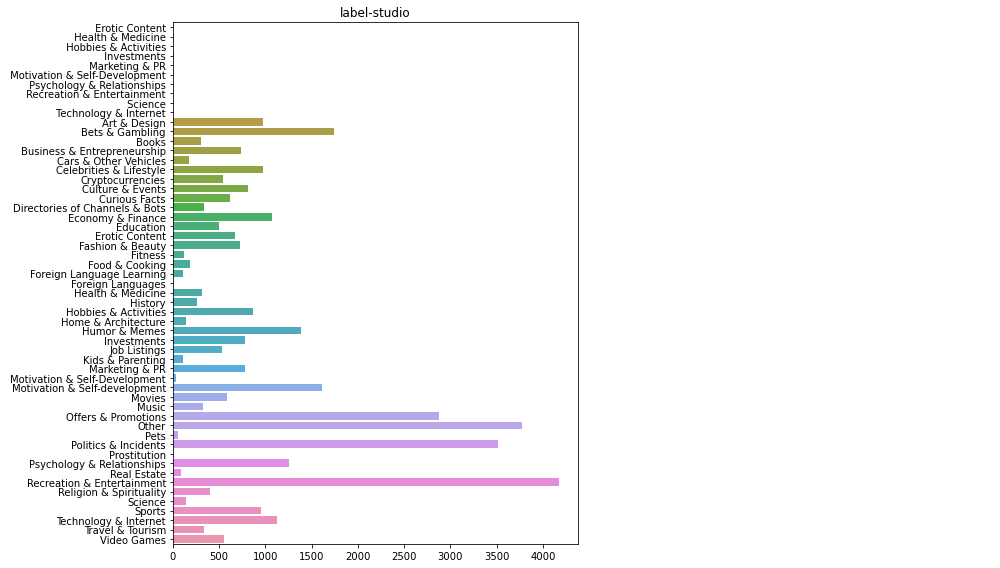

en


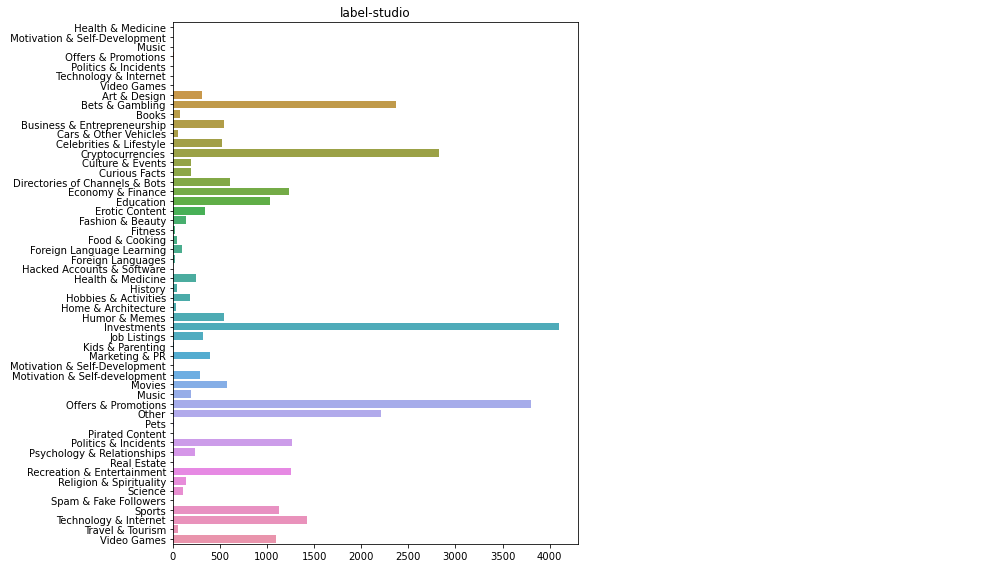

fa


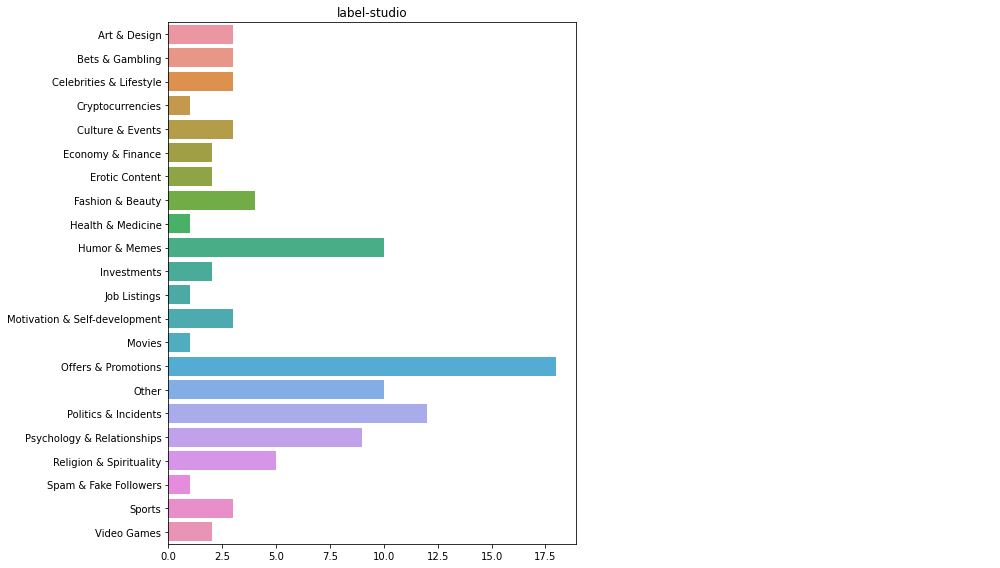

uz


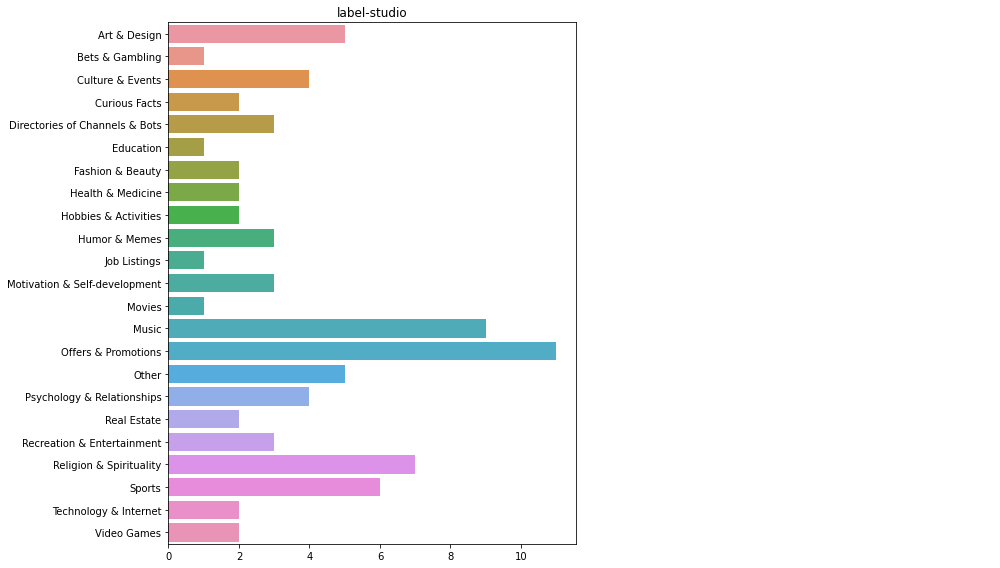

ar


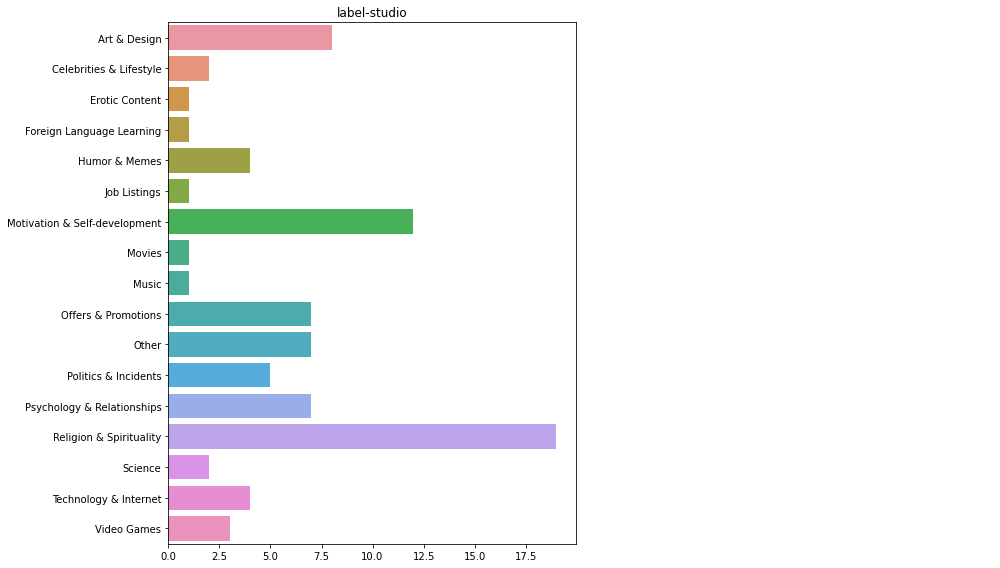

In [37]:
for l in train_data_flat['lang_code'].unique():
    print(l)
    barplots({
        'label-studio': train_data_flat.query(f"lang_code == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8))

In [38]:
print('Unique topics per language')
print(train_data_flat.groupby('lang_code')['topic'].nunique())

Unique topics per language
lang_code
ar    17
en    54
fa    22
ru    55
uz    23
Name: topic, dtype: int64


### Load stopwords

In [39]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
    'ar': 'data/external/ar_stopwords.txt'
}

In [40]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

734

## Experiments

**Improve:**
- [x] one common split for train and test
- [x] don't flatten test
- [ ] ~~cross-val when training~~
- [x] weighted metric
- [ ] ~~top-k accuracy metric~~

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.
- [ ] datasets {tg, r-1, r-2}
- [ ] ngrams, chars vs words

In [41]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, top_k_accuracy_score
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [42]:
from src.train.text_utils import tokenize_text

In [152]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, lang_code, preprocessing, vect, est, vect_params={}):
        self.LANG = lang_code
        self.train_inputs = train_data_flat.query(f"lang_code == {lang_code!r}").copy()
        self.test_inputs = test_data.query(f"lang_code == {lang_code!r}").copy()
        self.vect = VECTORIZERS[vect]
        if vect_params != {}:
            self.vect.set_params(**vect_params)
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(lang_code)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        if is_final:
            # before saving models train on full data
            
        else:
            # for research use train data for fitting and test for eval
            self.y_train = self.train_inputs['topic']
            self.sample_weights = self.train_inputs['weight']
            self.X_train = self.vect.fit_transform(self.train_inputs['text'])
            self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        try:
            self.clf.fit(self.X_train, self.y_train, sample_weight=self.sample_weights)
        except TypeError as e:
            logging.warning(e.args[0])
            self.clf.fit(self.X_train, self.y_train)
#         self.predictions = pd.DataFrame({
#                     'true': trainer.test_inputs['topics'],
#                     'predicted': trainer.clf.predict_proba(trainer.X_test)
#                 })
        predicted = trainer.clf.predict_proba(trainer.X_test)
        scores = score_predictions(trainer.test_inputs['category'], predicted, self.clf.classes_)

        return np.mean(scores)
    

def calc_weight_score(topic_weights, predicted_probs, classes):
    true_weights = np.zeros(len(classes))
    for t,w in topic_weights.items():
        index = np.argwhere(classes == t).squeeze()
        true_weights[index] = w
    mae = round(sum(abs(true_weights - predicted_probs)),4)
    return 1 / (1 + mae)


def score_predictions(true_topics, predicted_probs, classes):
    scores = list(map(lambda x: calc_weight_score(x[0],x[1],classes),
                         zip(true_topics, predicted_probs)))
    return scores

### Set hyper-parameters

In [153]:
PREPROCESSING = [
    'raw',
#     'lemma',
]

vect_params = dict(
    max_df=0.4, 
    min_df=3,
    max_features=500,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
    analyzer='word'
)
vect_space = [
    {
        'ngram_range': (1,1),
        'analyzer': 'word'
    },
    {
        'ngram_range': (3,5),
        'analyzer': 'char'
    },
    
]
VECTORIZERS = {
#     'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
#     cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [160]:

train_params = list(itertools.product(
    LANGS, 
    PREPROCESSING,
    VECTORIZERS.keys(), 
    ESTIMATORS.keys(),
    vect_space,
))

len(train_params)

10

#### Test trainer

In [170]:
trainer = Trainer(
    lang_code = 'ar', 
    preprocessing = 'raw',
    vect = 'bow', 
    est = 'mnb',
    vect_params={'max_features': 1001, 'min_df': 5}
)
s = trainer.run_eval(final=False)
print(s)

0.5891993615428046


### Run experiments

In [171]:
results = []

for params in tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['lang_code','preprocessing','vect', 'est', 'vect_params','score',])

# experiments:   0%|          | 0/10 [00:00<?, ?it/s]

In [172]:
for l in results['lang_code'].unique():
    print(results.query(f'lang_code == "{l}"').sort_values('score', ascending=False).to_markdown(), end='\n\n')

|    | lang_code   | preprocessing   | vect   | est   | vect_params                                 |    score |
|---:|:------------|:----------------|:-------|:------|:--------------------------------------------|---------:|
|  0 | ru          | raw             | bow    | mnb   | {'ngram_range': (1, 1), 'analyzer': 'word'} | 0.640358 |
|  1 | ru          | raw             | bow    | mnb   | {'ngram_range': (3, 5), 'analyzer': 'char'} | 0.568753 |

|    | lang_code   | preprocessing   | vect   | est   | vect_params                                 |    score |
|---:|:------------|:----------------|:-------|:------|:--------------------------------------------|---------:|
|  2 | en          | raw             | bow    | mnb   | {'ngram_range': (1, 1), 'analyzer': 'word'} | 0.633695 |
|  3 | en          | raw             | bow    | mnb   | {'ngram_range': (3, 5), 'analyzer': 'char'} | 0.471271 |

|    | lang_code   | preprocessing   | vect   | est   | vect_params                           

### Review errors

#### Train

In [173]:
trainer = Trainer(
    lang_code = 'ar', 
    preprocessing = 'raw',
    vect = 'bow', 
    est = 'mnb'
)
s = trainer.run_eval(final=False)
print(s)

0.5646792225001015


In [174]:
test_pred = trainer.clf.predict_proba(trainer.X_test)

# is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs.copy()

errors['score'] = score_predictions(errors['category'], test_pred, trainer.clf.classes_)

#### random examples

In [175]:
def get_top_classes(probs, classes):
    top_inds = np.argwhere(probs > probs.mean()).squeeze(1)
    return Counter({classes[i]:probs[i] for i in top_inds})

In [183]:
i = random.randint(0, len(errors)-1)
row = errors.iloc[i]
pred = get_top_classes(test_pred[i], trainer.clf.classes_)

# print('PREDICTED:\n', row['predicted'], end='\n\n')
print('MAE:\n', row['score'], end='\n\n')
print('TRUE:\n', row['category'], end='\n\n')
print('PREDICTED:\n', pred, end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
# print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
# print('DESCRIPTION:\n', row['description'], end='\n\n')

MAE:
 0.35294532876857376

TRUE:
 {'Motivation & Self-development': 0.5, 'Art & Design': 0.16666666666666666, 'Hobbies & Activities': 0.16666666666666666, 'Music': 0.16666666666666666}

PREDICTED:
 Counter({'Humor & Memes': 0.9999912932654985})

TEXTS:
 اقفوبكك
تغانمو الوصّل دام الارواح حيه⚚‏
        شمال سيناء 𓅔
قناة [الخمّايل] المعروفه متذوقه للقصيد تضع مايروق لها في قناتها بـ قصائدها الجزله وصور تختلف عن باقي القنوات أنضمو لها تستاهل🤍.
https://t.me/lvza54
قناة [الخمّايل] المعروفه متذوقه للقصيد تضع مايروق لها في قناتها بـ قصائدها الجزله وصور تختلف عن باقي القنوات أنضمو لها تستاهل🤍.
https://t.me/lvza54
__
فمان الله ياروح الغرام اللي نويت أنساه 
فمان الله يابسمة شقايّ وجرحي الدامي
ٰ             - ابن فطيس : 
قللبي الا منننـه شرا قلب ماببااع
وانت الله الله فيه والعمر موقوت.



#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [184]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [185]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb':
            if probs.std(0) < 0.0001:
                return {"Other": 1.0}
        else:
            if probs.max() < 0.1:
                return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [201]:
V = 'bow'
E = 'mnb'
L = 'uz'

trainer = Trainer(
    lang_code = L, 
    preprocessing = 'raw',
    vect = V, 
    est = E,
)
_ = trainer.run_eval(final=False)

tgcat = TgCat(TextVectorizer(V, trainer.vect), NaiveBayes(E, trainer.clf), top_k=3)

In [202]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [203]:
v = tgcat.vect(batch)
p = tgcat.clf(v)

In [204]:
tgcat([['a','s','d'], [""], ["other", 'other', 'ttt'], ["чгк", "нияег", "его"]])

[{'Offers & Promotions': 0.358974358974359,
  'Sports': 0.3205128205128205,
  'Religion & Spirituality': 0.3205128205128205},
 {'Offers & Promotions': 0.358974358974359,
  'Sports': 0.3205128205128205,
  'Religion & Spirituality': 0.3205128205128205},
 {'Offers & Promotions': 0.358974358974359,
  'Sports': 0.3205128205128205,
  'Religion & Spirituality': 0.3205128205128205},
 {'Offers & Promotions': 0.358974358974359,
  'Sports': 0.3205128205128205,
  'Religion & Spirituality': 0.3205128205128205}]

In [207]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'Humor & Memes': 1.0}

TOKENS ['dunyozoda', 'rasmiy', 'kiramiz', 'davay', 'me', 'dunyozoda', 'tik', 'tok', 'kirib', 'fikrizni', 'bildiring']


### Final training, convert and save

In [208]:
from sklearn.preprocessing import normalize

In [209]:
prediction_params = {
    'top_k': 3
}

In [210]:
for l in results['lang_code'].unique():
    subset = results.query(f"lang_code == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    print(l, 'best', best_params)
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect), )
    tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    src_vects = trainer.X_test.toarray()
    assert np.allclose(src_vects, vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru best {'lang_code': 'ru', 'preprocessing': 'raw', 'vect': 'bow', 'est': 'mnb', 'vect_params': {'ngram_range': (1, 1), 'analyzer': 'word'}, 'score': 0.6403583648437308}
ru 0.6403583648437308
saved to models/trained/tgcat/ru_tgcat.pt
en best {'lang_code': 'en', 'preprocessing': 'raw', 'vect': 'bow', 'est': 'mnb', 'vect_params': {'ngram_range': (1, 1), 'analyzer': 'word'}, 'score': 0.6336953947275061}
en 0.6336953947275061
saved to models/trained/tgcat/en_tgcat.pt
fa best {'lang_code': 'fa', 'preprocessing': 'raw', 'vect': 'bow', 'est': 'mnb', 'vect_params': {'ngram_range': (1, 1), 'analyzer': 'word'}, 'score': 0.5304678669844852}
fa 0.5304678669844852
saved to models/trained/tgcat/fa_tgcat.pt
uz best {'lang_code': 'uz', 'preprocessing': 'raw', 'vect': 'bow', 'est': 'mnb', 'vect_params': {'ngram_range': (1, 1), 'analyzer': 'word'}, 'score': 0.5042743097304478}
uz 0.5042743097304478
saved to models/trained/tgcat/uz_tgcat.pt
ar best {'lang_code': 'ar', 'preprocessing': 'raw', 'vect': 'bow

### Check file sizes

In [211]:
!du -hm models/trained/*/* | sort -nr

9	models/trained/embed/uz_tfidf_script.pt
9	models/trained/embed/ru_tfidf_script.pt
9	models/trained/embed/fa_tfidf_script.pt
9	models/trained/embed/en_tfidf_script.pt
9	models/trained/embed/ar_tfidf_script.pt
6	models/trained/tgcat/ru_tgcat.pt
6	models/trained/tgcat/fa_tgcat.pt
6	models/trained/tgcat/en_tgcat.pt
6	models/trained/embed/ru_bow_script.pt
6	models/trained/embed/en_bow_script.pt
5	models/trained/embed/fa_bow_script.pt
1	models/trained/tgcat/uz_tgcat.pt.dvc
1	models/trained/tgcat/uz_tgcat.pt
1	models/trained/tgcat/ru_tgcat.pt.dvc
1	models/trained/tgcat/fa_tgcat.pt.dvc
1	models/trained/tgcat/en_tgcat.pt.dvc
1	models/trained/tgcat/ar_tgcat.pt.dvc
1	models/trained/tgcat/ar_tgcat.pt
1	models/trained/embed/uz_bow_script.pt
1	models/trained/embed/ru_bow.txt
1	models/trained/embed/ar_bow_script.pt
1	models/trained/classify/uz_mnb_script.pt
1	models/trained/classify/uz_cnb_script.pt
1	models/trained/classify/ru_mnb_script.pt
1	models/trained/classify/ru_cnb_script.pt
1	models/train